In [1]:
import os
import glob

import torch
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
# import cv2
from PIL import Image
import numpy as np

In [4]:
from torch.utils.data import DataLoader
from config import train_config as config

In [5]:
img_width = config['img_width']
img_height = config['img_height']
data_dir = config['data_dir']
train_batch_size = config['train_batch_size']
cpu_workers = config['cpu_workers']

In [2]:
def _load_from_raw_files(root_dir, mode):
    mapping = {}
    with open(os.path.join(root_dir, 'lexicon.txt'), 'r') as fr:
        for i, line in enumerate(fr.readlines()):
            mapping[i] = line.strip()

    paths_file = None
    if mode == 'train':
        paths_file = 'annotation_train.txt'
    elif mode == 'dev':
        paths_file = 'annotation_val.txt'
    elif mode == 'test':
        paths_file = 'annotation_test.txt'

    paths = []
    texts = []
    with open(os.path.join(root_dir, paths_file), 'r') as fr:
        for line in fr.readlines():
            path, index_str = line.strip().split(' ')
            path = os.path.join(root_dir, path)
            index = int(index_str)
            text = mapping[index]
            paths.append(path)
            texts.append(text)
    return paths, texts

In [7]:
paths, texts = _load_from_raw_files(data_dir, 'train')

In [12]:
data_dir

'../data/labels'

In [11]:
os.path.join(data_dir, paths[0])

'/raw\\1\\100_mainstream_46149.jpg'

['/raw\\1\\100_mainstream_46149.jpg',
 '/raw\\1\\101_malformation_46266.jpg',
 '/raw\\1\\102_camouflagers_11040.jpg',
 '/raw\\1\\103_Lubricator_45496.jpg',
 '/raw\\1\\105_Consuelo_16408.jpg',
 '/raw\\1\\106_irs_40905.jpg',
 '/raw\\1\\108_Middlemost_48276.jpg',
 '/raw\\1\\109_Glitziest_32763.jpg',
 '/raw\\1\\10_greenness_33644.jpg',
 '/raw\\1\\114_PHANTASMAGORICAL_57115.jpg',
 '/raw\\1\\115_Sixes_71194.jpg',
 '/raw\\1\\116_Egregious_24814.jpg',
 '/raw\\1\\117_wreckage_87383.jpg',
 '/raw\\1\\119_Nz_52697.jpg',
 '/raw\\1\\11_beach_6368.jpg',
 '/raw\\1\\120_NOTING_52403.jpg',
 '/raw\\1\\121_Recovering_63367.jpg',
 '/raw\\1\\122_Production_60327.jpg',
 '/raw\\1\\123_PURUS_61435.jpg',
 '/raw\\1\\124_DEVASTATION_21248.jpg',
 '/raw\\1\\127_Existence_27270.jpg',
 '/raw\\1\\128_Deodorants_20662.jpg',
 '/raw\\1\\129_enthusing_26020.jpg',
 '/raw\\1\\12_WESTERNIZING_86069.jpg',
 '/raw\\1\\130_inventor_40602.jpg',
 '/raw\\1\\132_Greengrocers_33633.jpg',
 '/raw\\1\\133_Subcategory_75517.jpg',
 '/raw\

In [2]:
class Synth90kDataset(Dataset):
    CHARS = '0123456789abcdefghijklmnopqrstuvwxyz'
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, root_dir=None, mode=None, paths=None, img_height=32, img_width=100):
        if root_dir and mode and not paths:
            paths, texts = self._load_from_raw_files(root_dir, mode)
        elif not root_dir and not mode and paths:
            texts = None

        self.paths = paths
        self.texts = texts
        self.img_height = img_height
        self.img_width = img_width

    def _load_from_raw_files(self, root_dir, mode):
        mapping = {}
        with open(os.path.join(root_dir, 'lexicon.txt'), 'r') as fr:
            for i, line in enumerate(fr.readlines()):
                mapping[i] = line.strip()

        paths_file = None
        if mode == 'train':
            paths_file = 'annotation_train.txt'
        elif mode == 'dev':
            paths_file = 'annotation_val.txt'
        elif mode == 'test':
            paths_file = 'annotation_test.txt'

        paths = []
        texts = []
        with open(os.path.join(root_dir, paths_file), 'r') as fr:
            for line in fr.readlines():
                path, index_str = line.strip().split(' ')
                path = os.path.join(root_dir, path)
                index = int(index_str)
                text = mapping[index]
                paths.append(path)
                texts.append(text)
        return paths, texts

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]

        try:
            image = Image.open(path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % index)
            return self[index + 1]

        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)
        if self.texts:
            text = self.texts[index]
            target = [self.CHAR2LABEL[c] for c in text]
            target_length = [len(target)]

            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)
            # 如果DataLoader不设置collate_fn,则此处返回值为迭代DataLoader时取到的值
            return image, target, target_length
        else:
            return image


In [3]:
def synth90k_collate_fn(batch):
    # zip(*batch)拆包
    images, targets, target_lengths = zip(*batch)
    # stack就是向量堆叠的意思。一定是扩张一个维度，然后在扩张的维度上，把多个张量纳入仅一个张量。想象向上摞面包片，摞的操作即是stack，0轴即按块stack
    images = torch.stack(images, 0)
    # cat是指向量拼接的意思。一定不扩张维度，想象把两个长条向量cat成一个更长的向量。
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    # 此处返回的数据即使train_loader每次取到的数据，迭代train_loader，每次都会取到三个值，即此处返回值。
    return images, targets, target_lengths

In [9]:
data_dir

'../data/labels'

ERROR! Session/line number was not unique in database. History logging moved to new session 3945


In [8]:
train_dataset = Synth90kDataset(root_dir=data_dir, mode='train',
                                    img_height=img_height, img_width=img_width)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=cpu_workers,
    collate_fn=synth90k_collate_fn)

In [8]:
train_data = train_dataset.__getitem__(136)

Corrupted image for 136
Corrupted image for 137
Corrupted image for 138
Corrupted image for 139
Corrupted image for 140
Corrupted image for 141
Corrupted image for 142
Corrupted image for 143
Corrupted image for 144
Corrupted image for 145
Corrupted image for 146
Corrupted image for 147
Corrupted image for 148
Corrupted image for 149
Corrupted image for 150
Corrupted image for 151
Corrupted image for 152
Corrupted image for 153
Corrupted image for 154
Corrupted image for 155
Corrupted image for 156
Corrupted image for 157
Corrupted image for 158
Corrupted image for 159
Corrupted image for 160
Corrupted image for 161
Corrupted image for 162
Corrupted image for 163
Corrupted image for 164
Corrupted image for 165
Corrupted image for 166
Corrupted image for 167
Corrupted image for 168
Corrupted image for 169
Corrupted image for 170
Corrupted image for 171
Corrupted image for 172
Corrupted image for 173
Corrupted image for 174
Corrupted image for 175
Corrupted image for 176
Corrupted image 

Corrupted image for 701
Corrupted image for 702
Corrupted image for 703
Corrupted image for 704
Corrupted image for 705
Corrupted image for 706
Corrupted image for 707
Corrupted image for 708
Corrupted image for 709
Corrupted image for 710
Corrupted image for 711
Corrupted image for 712
Corrupted image for 713
Corrupted image for 714
Corrupted image for 715
Corrupted image for 716
Corrupted image for 717
Corrupted image for 718
Corrupted image for 719
Corrupted image for 720
Corrupted image for 721
Corrupted image for 722
Corrupted image for 723
Corrupted image for 724
Corrupted image for 725
Corrupted image for 726
Corrupted image for 727
Corrupted image for 728
Corrupted image for 729
Corrupted image for 730
Corrupted image for 731
Corrupted image for 732
Corrupted image for 733
Corrupted image for 734
Corrupted image for 735
Corrupted image for 736
Corrupted image for 737
Corrupted image for 738
Corrupted image for 739
Corrupted image for 740
Corrupted image for 741
Corrupted image 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



RecursionError: maximum recursion depth exceeded

In [26]:
print(f'train_data的类型是：{type(train_data)}')
print(f'train_data的长度是：{len(train_data)}')

train_data的类型是：<class 'tuple'>
train_data的长度是：3


In [27]:
train_data

(tensor([[[0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2863, 0.3020],
          [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2941, 0.2941],
          [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.3020, 0.2941],
          ...,
          [0.2941, 0.3020, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
          [0.3020, 0.2863, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
          [0.3176, 0.2784, 0.3020,  ..., 0.2941, 0.2941, 0.2941]]]),
 tensor([14, 15, 30, 15, 28, 23, 19, 24, 11, 24, 30, 29]),
 tensor([12]))

In [28]:
img = train_data[0]
label_idx = train_data[1]
label_length = train_data[2]

In [29]:
print(f'img的类型是：{type(img)}')
print(f'img的shape是：{img.shape}')
print('img matrix如下:')
print(img)

img的类型是：<class 'torch.Tensor'>
img的shape是：torch.Size([1, 32, 100])
img matrix如下:
tensor([[[0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2863, 0.3020],
         [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2941, 0.2941],
         [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.3020, 0.2941],
         ...,
         [0.2941, 0.3020, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
         [0.3020, 0.2863, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
         [0.3176, 0.2784, 0.3020,  ..., 0.2941, 0.2941, 0.2941]]])


In [30]:
import matplotlib.pyplot as plt

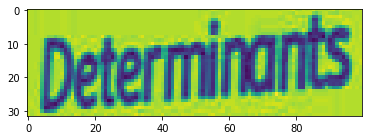

In [31]:
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.show()

In [32]:
chars = '0123456789abcdefghijklmnopqrstuvwxyz'
label = ''
for idx in label_idx:
    label += chars[idx-1]
print(f'label为：{label}')

label为：determinants
